In [3]:
import glob
import torch
import codecs
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
import sys
sys.path.append( '/anaconda/envs/py37_pytorch/lib/python3.7')
sys.path.append('/anaconda/envs/py37_pytorch/lib/python3.7/site-packages')

In [4]:
'''新疆：东经75°到东经95°;纬度:北纬35°到北纬50°
东三省：经度为118°E-135°E,纬度为39-51
河北：东经110-122.32,北纬32.6-40.62
东南沿海:东经108.85-121.22,北纬22.6,32.73'''

area_lat_lon = {'xibei':[74,97,28,50],
      'dongsanshen':[119,135,39,51],
      'hebei':[110,122.32,32.6,40.62],
      'dongnan':[108.85,121.22,22.6,32.73],
       'xinan':[98,108.85,22.6,32.73],
      }

node_distribution = {i:np.zeros((182,232)).astype(np.bool) for i in area_lat_lon}


station2idx = {}
with codecs.open("/AS_data/DATA/monitorij_cn27_prov.txt",'r',"utf-8") as f:
    for i in f.readlines():
        line = i.rstrip().split('\t')
        east_west,north_south = float(line[4]),float(line[5])
        station2idx[line[0]]=(int(line[-2]),int(line[-1]))
        for area in area_lat_lon:
            if area_lat_lon[area][0]<east_west<area_lat_lon[area][1] and area_lat_lon[area][2]<north_south<area_lat_lon[area][3]:
                node_distribution[area][station2idx[line[0]][1],station2idx[line[0]][0]] += 1
                
# for i in node_distribution:
#     print(i)
#     plt.imshow(node_distribution[i][::-1])
#     plt.show()

In [3]:
area_lat_lon = {'xinjiang':[48,139],'beijing':[136,115],'tianjin':[139,112],'shijiazhuang':[130,107],'ningbo':[157,76],'lanzhou':[96,99],'xian':[112,91]}
node_distribution = {i:np.zeros((182,232)).astype(np.bool) for i in area_lat_lon}
for city in area_lat_lon:
    node_distribution[city][area_lat_lon[city][1]][area_lat_lon[city][0]] = True
node_distribution

{'xinjiang': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'beijing': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'tianjin': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [Fa

In [6]:
obs_labels = []
for filename in sorted(glob.glob('/AS_data/obs_npy/obs2015_10*')):
    print(filename+'   is loading')
    obs_label = np.load(filename)
    tick,_,W,H = obs_label.shape
    obs_labels.append(obs_label[:,2].copy())
#     del obs_label

fine_inputs = []
for filename in sorted(glob.glob('/AS_data/finetune_input_prelu_VOCsame_PM25_O3_NO2_SO2/rest_4month_SULF_CO_7dim_10*')):
    print(filename+'   is loading')
    EM = np.load(filename)
    tick,_,W,H = EM.shape
    print(tick)
    fine_inputs.append(EM[:].copy())

org_inputs = []
for filename in sorted(glob.glob('/AS_data/zeyuan_folder/concat_data/rest_EM_2015_10_744_07*')):
    print(filename+'   is loading')
    EM = np.load(filename)
    tick,_,W,H = EM.shape
    print(tick)
    org_inputs.append(EM[:].copy())

/AS_data/obs_npy/obs2015_10_744_6_182_232.npy   is loading
/AS_data/finetune_input_prelu_VOCsame_PM25_O3_NO2_SO2/rest_4month_SULF_CO_7dim_10_finetune_input.npy   is loading
744
/AS_data/zeyuan_folder/concat_data/rest_EM_2015_10_744_07_182_232.npy   is loading
744


In [7]:
# dic = {0: 'ALD2', 1: 'CO', 2: 'ETH', 3: 'FORM', 4: 'ISOP', 5: 'NH3', 6: 'NO', 7: 'NO2', 8: 'UNR', 9: 'OLE', 10: 'PAR', 11: 'PEC', 12: 'PMC', 13: 'PMOTHR', 14: 'PNO3', 15: 'POC', 16: 'PSO4', 17: 'PCL', 18: 'PNH4', 19: 'PNA', 20: 'PMG', 21: 'PK', 22: 'PCA', 23: 'PNCOM', 24: 'PFE', 25: 'PAL', 26: 'PSI', 27: 'PTI', 28: 'PMN', 29: 'PH2O', 30: 'SO2', 31: 'SULF', 32: 'TERP', 33: 'TOL', 34: 'XYL', 35: 'MEOH', 36: 'ETOH', 37: 'ETHA', 38: 'ALDX', 39: 'IOLE', 40: 'CH4', 41: 'AACD', 42: 'NAPH', 43: 'NR', 44: 'SOAALK', 45: 'XYLMN', 46: 'PRPA', 47: 'BENZ', 48: 'ETHY', 49: 'ACET', 50: 'KET'}
# dic = {0:'CO', 1:'NH3', 2:'NO', 3:'NO2', 4:'SO2', 5:'SULF', 6:'voc_mean', 7:'p_mean'}
dic = {0:'CO', 1:'NH3', 2:'SO2', 3:'SULF', 4:'voc_mean', 5:'p_mean', 6:'no_mean'}
# import numpy as np
# idx_search = [0,2,3,4,9,32, 34, 35, 36, 37, 39, 42, 43, 44, 46, 47,]
# def combination(nums):
#     if len(nums) == 1:
#         return [[nums[0]],[]]
#     f1_end = combination(nums[1:])
#     return [[nums[0]]+i for i in f1_end]+f1_end


# combine_idx_search = [idx_search[:i]+idx_search[i+1:] for i in range(len(idx_search))] + idx_search
# len(combine_idx_search)
# # combine_idx_search = [np.array(i) for i in combination(idx_search)]


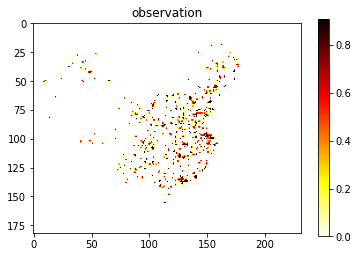

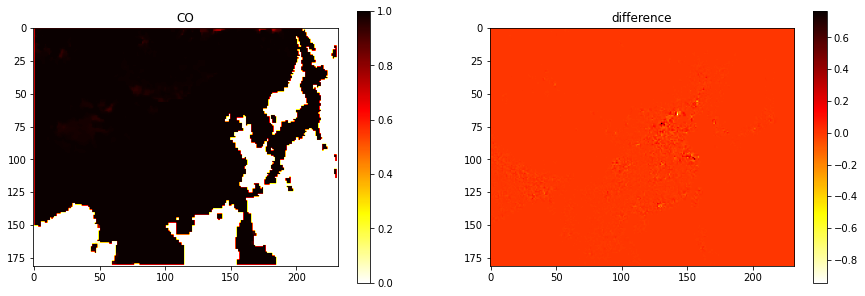

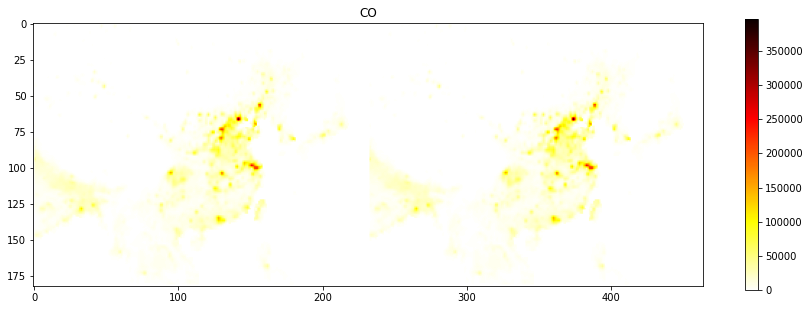

0.03865740505642578


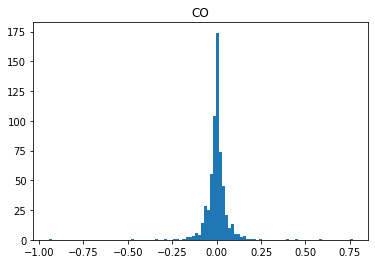

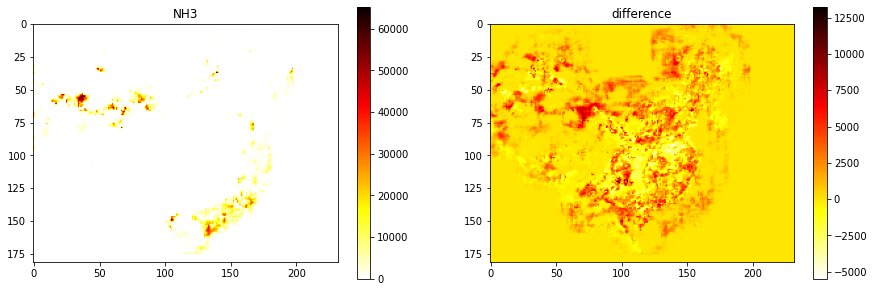

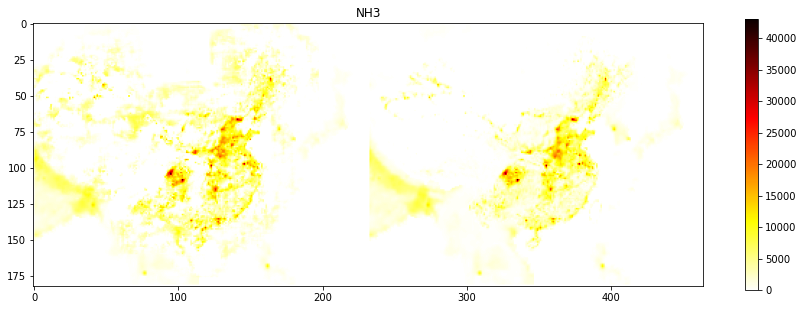

3090.3483679911396


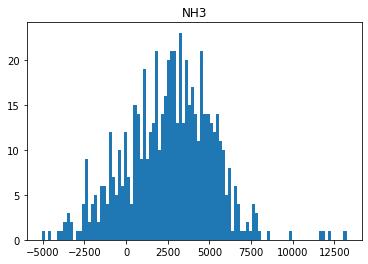

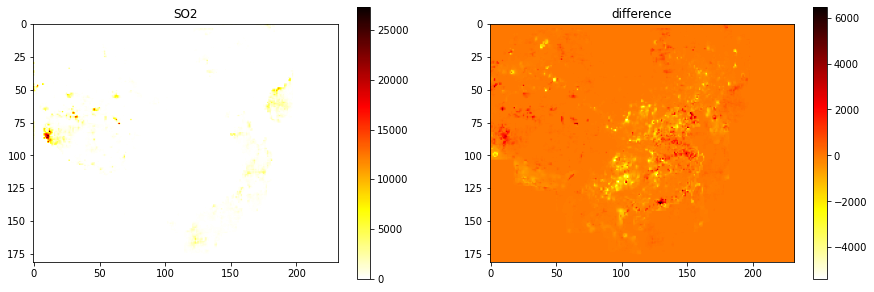

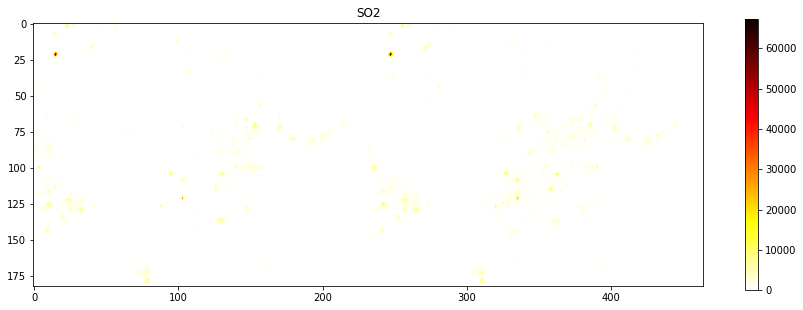

918.5430796379266


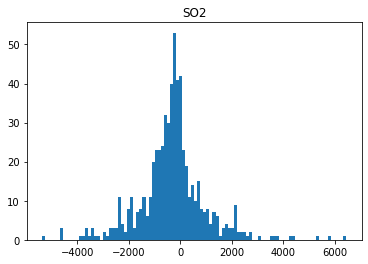

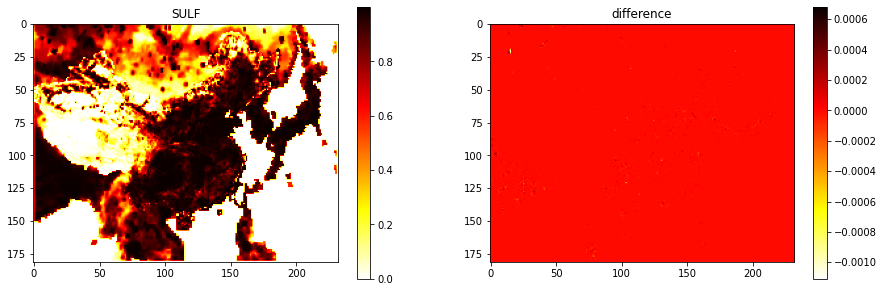

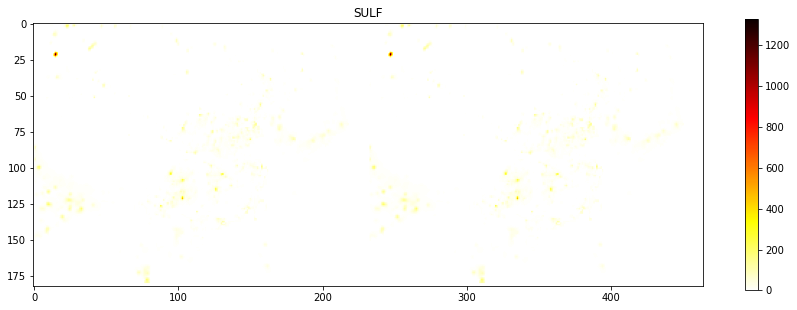

1.8536307364408204e-05


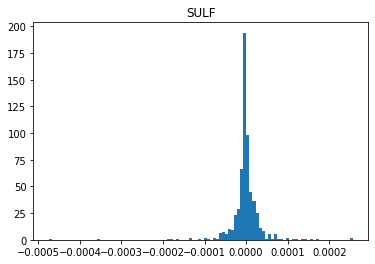

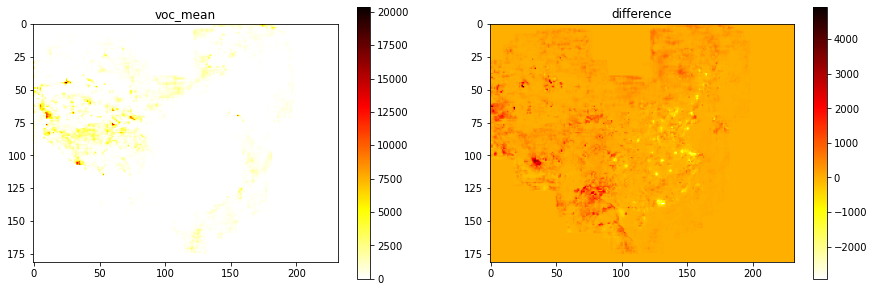

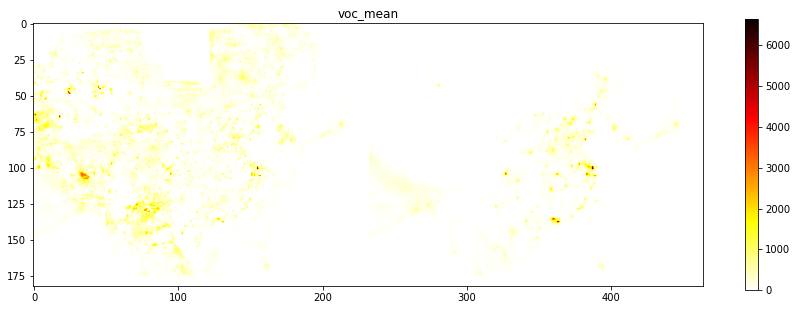

352.56981865449154


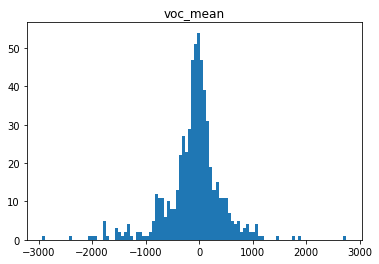

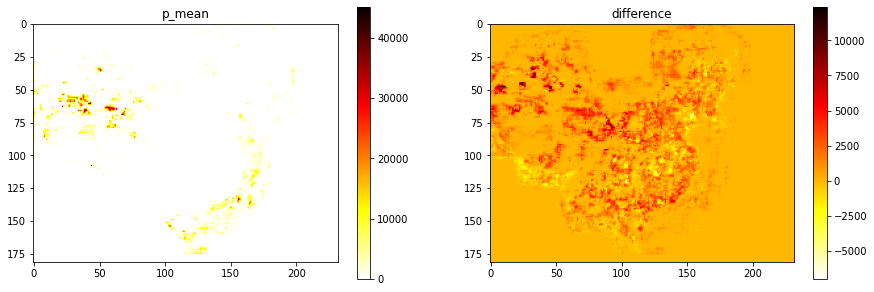

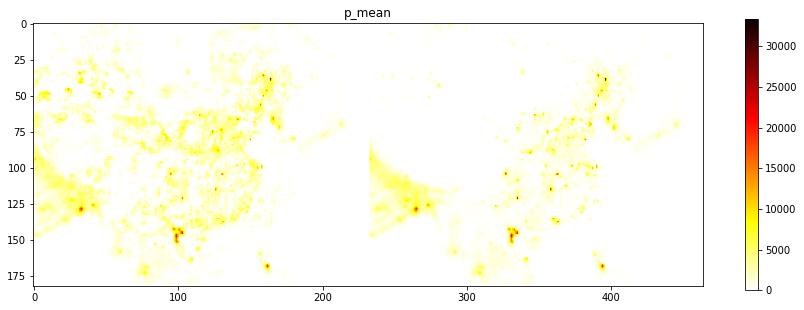

1532.767199289607


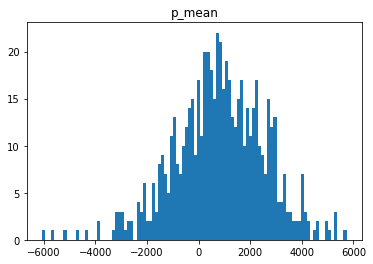

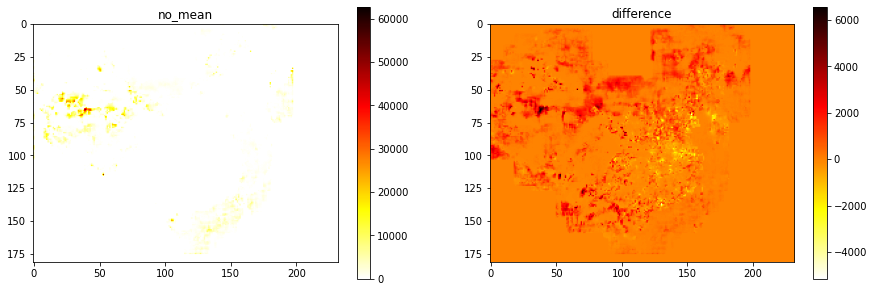

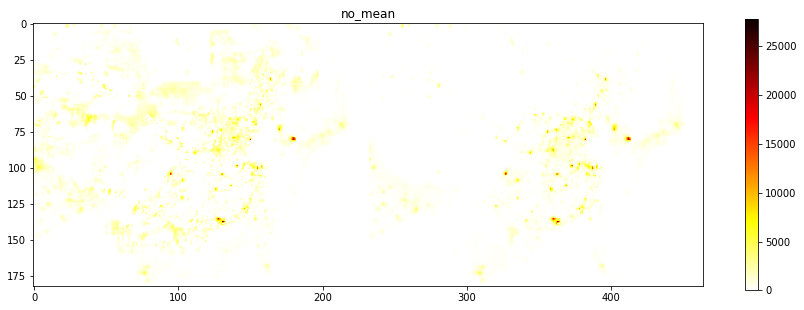

844.3846256477352


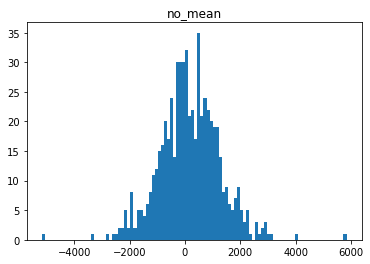

In [10]:
for i in range(1): #len(fine_inputs)):
    obs_label = obs_labels[i].copy()
    obs_label[obs_label>0] = 1
    obs_label[obs_label<=0] = 0
    obs_label = np.mean(obs_label,axis = 0)
    plt.imshow(obs_label[::-1],cmap=plt.cm.hot_r)
    plt.title('observation')
    plt.colorbar()
    plt.show()
    
    for em_idx in range(7): #fine_inputs[0].shape[1]):
        fine_input = fine_inputs[i][:,em_idx].copy()
        org_input = org_inputs[i][:,em_idx].copy()
        
        fine_input = np.sum(fine_input,axis = 0)
        org_input = np.sum(org_input,axis = 0)
#         org_input[org_input == 0] = 1e-1
        plt.figure(figsize=(15,5))    
        plt.subplot(1,2,1)
        a = fine_input/(org_input+1e-1)

        plt.imshow(a[::-1],cmap=plt.cm.hot_r)
        plt.title(dic[em_idx])
        plt.colorbar()
#         plt.show()

        plt.subplot(1,2,2)
        a = fine_input - org_input
        plt.imshow(a[::-1],cmap=plt.cm.hot_r)
        plt.title('difference')
        plt.colorbar()
        plt.show()
        
        plt.figure(figsize=(15,5))
        plt.imshow(np.concatenate([fine_input[::-1],org_input[::-1]],axis = 1),cmap=plt.cm.hot_r)
        plt.title(dic[em_idx])
        plt.colorbar()
        plt.show()
        
        a = a[obs_label>0.5]
        print(np.mean(np.abs(a[a!=0])))
        plt.hist(a[a!=0].reshape(-1),bins = 100)
        plt.title(dic[em_idx])
        plt.show()

In [ ]:
len(fine_inputs)

---------


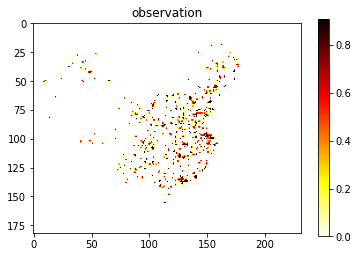

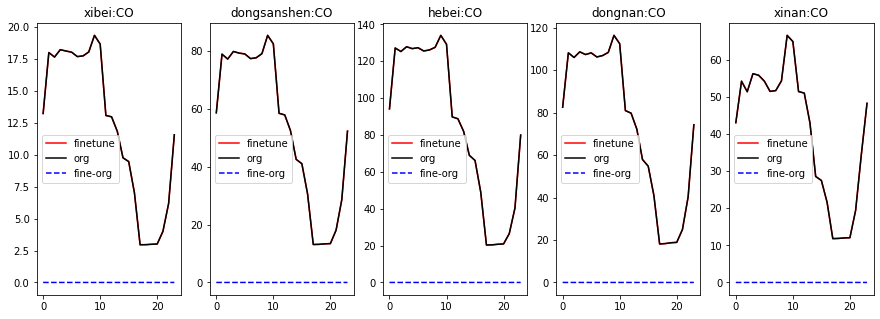

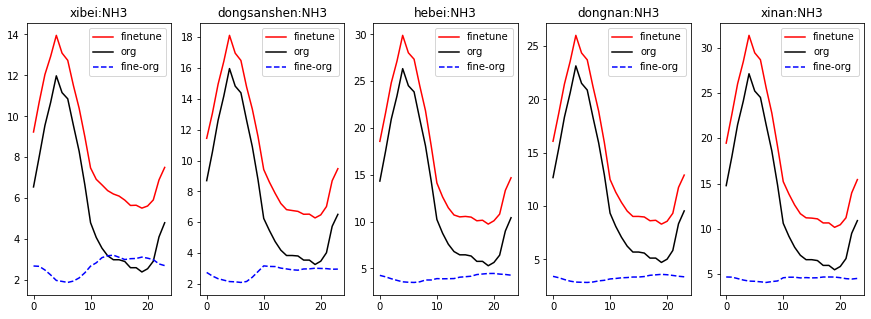

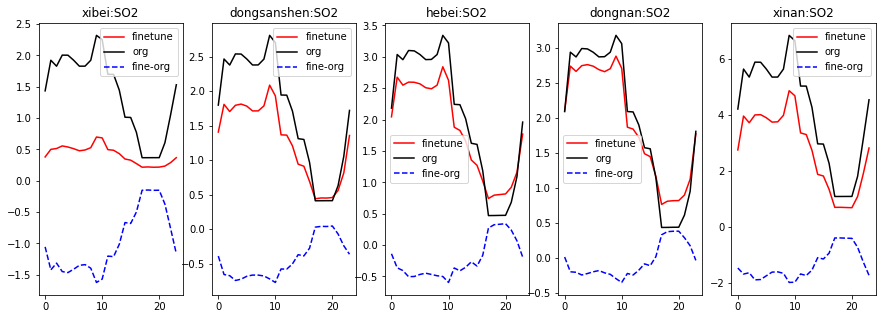

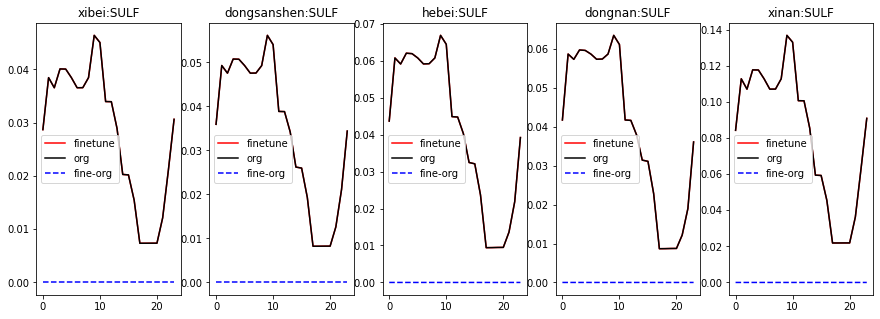

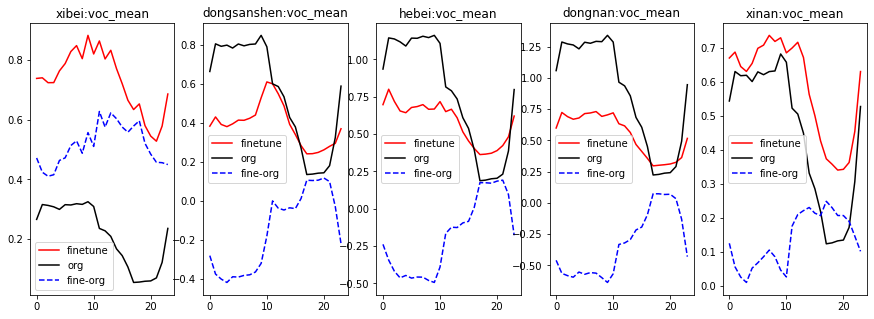

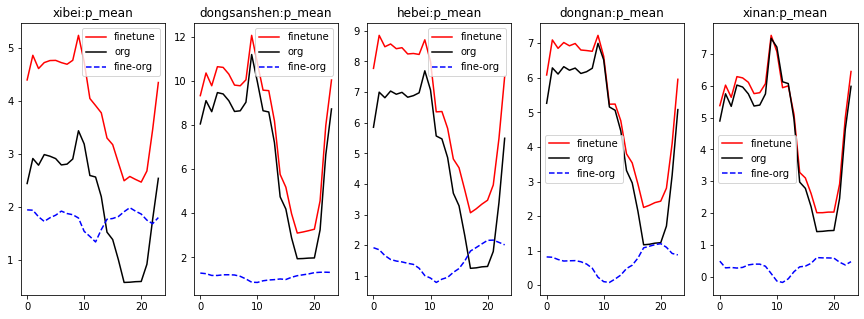

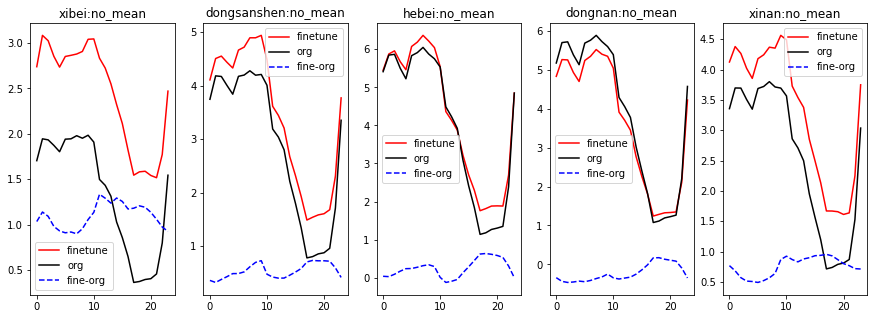

In [11]:
# for i in np.array([0,2,3,4,8,9,10] + list(range(32,51))): #len(fine_inputs)):
for i in range(1):
    print('---------')
    obs_label = obs_labels[i].copy()
    obs_label[obs_label>0] = 1
    obs_label[obs_label<=0] = 0
    obs_label = np.mean(obs_label,axis = 0)
    plt.imshow(obs_label[::-1],cmap=plt.cm.hot_r)
    plt.title('observation')
    plt.colorbar()
    plt.show()
    
    for em_idx in range(7): #fine_inputs[0].shape[1]):
        fine_input = fine_inputs[i][:,em_idx].copy()
        org_input = org_inputs[i][:,em_idx].copy()
        
        plt.figure(figsize=(15,5))
        for order,area in enumerate(node_distribution):
            
            area_fine_input = np.mean(fine_input[:,node_distribution[area]],axis = -1)
            area_org_input = np.mean(org_input[:,node_distribution[area]],axis = -1)
            
            area_fine_input = area_fine_input.reshape(-1,24)
            area_org_input = area_org_input.reshape(-1,24)
            
            area_fine_input = np.mean(area_fine_input,axis = 0)
            area_org_input = np.mean(area_org_input,axis = 0)
            
            plt.subplot(1,len(node_distribution),order+1)
            plt.plot(area_fine_input,'r')
            plt.plot(area_org_input,'k')
            plt.plot(area_fine_input-area_org_input,'b--')
            plt.legend(['finetune','org','fine-org'])
            plt.title(area+':'+dic[em_idx])
        plt.show()
        


In [ ]:
em_idx

In [ ]:
node_distribution.keys()